# 4 Training and Modeling Data<a id='4_Training_and_Modeling_Data'></a>

## Contents <a id ="Content" > </a>

* [Introduction](#Introduction)
* [Imports](#Imports)
* [Train Test Split](#Train_Test_Split) 
* [Training and Modeling](#Training_and_Modeling)
    * [Model Selection](#Model_Selection)
    * [Evaluation Metrics](#Evaluation-Metrics)
        * [Training and Modeling](#Train_and_Model)
        * [Hyperparameter Tuning and Model Training](#Hyperparameter_Tuning_Training)
            * [Logistic Regression](#Logistic_Regression)
            * [Evaluation](#Evaluation)
* [Additional Models](#AdditionalModels)
* [Summary](#Summary)
* [Recommendations](#Recom)

## Imports <a id="Imports"></a>

In [1]:
import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn import pipeline
from sklearn import model_selection
from sklearn import linear_model
from sklearn import ensemble
from sklearn import neighbors
from xgboost import XGBClassifier

#from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

#from sklearn.model_selection import StratifiedShuffleSplit,GridSearchCV
import matplotlib.pyplot as plt

# remove warning
#import warnings
#warnings.filterwarnings("ignore")


In [2]:
evaluation = pd.DataFrame(index=[],columns =[])

In [3]:
def threshhold_and_plot(y_test,target,title,n_points=50,plot=True,isTrain=False):
    probs = np.linspace(0,1,n_points)
    def make_thresh(): 
        precision = [metrics.precision_score(y_test,np.where(target > thresh,1,0),zero_division=1) for thresh in probs]
        recall = [metrics.recall_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target),zero_division=1) for thresh in probs]
        f1 = [metrics.f1_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target),zero_division=1) for thresh in probs]
        PR_AUC = metrics.auc(x=recall, y=precision)
        ROC_AUC = [metrics.roc_auc_score(y_test,np.where(target > thresh,1,0),labels=np.unique(target)) for thresh in probs]

        return precision,recall,f1,PR_AUC,ROC_AUC
    precision,recall,f1,PR_AUC,ROC_AUC = make_thresh()
    ix = np.argmax(recall)
    print('Threshold=%.3f, recall-Score=%.5f'% (probs[ix],recall[ix]))
    ix = np.argmax(precision)
    print('Threshold=%.3f, precision-Score=%.5f '%(probs[ix], precision[ix]))
    ix = np.argmax(f1)
    print('Threshold=%.3f, f1-Score=%.5f '%(probs[ix],f1[ix]))
    ix = np.argmax(f1)
    print('Threshold=%.3f, ROC_AUC=%.5f' % (probs[ix],ROC_AUC[ix]))
    print('PR_AUC=%.5f' % (PR_AUC))
    
    
    #PR_score = metrics.auc(x=recall, y=precision)
    
    prefix = 'Test_'
    if isTrain:
        prefix = 'Train_'
    evaluation.loc[title,prefix+'Recall'] = recall[ix]
    evaluation.loc[title,prefix+'Precision'] = precision[ix]
    evaluation.loc[title,prefix+'F1'] = f1[ix]
    evaluation.loc[title,prefix+'ROC_AUC'] = ROC_AUC[ix]
    evaluation.loc[title,prefix+'PR_score'] = PR_AUC

    if plot:
        fig,ax=plt.subplots(figsize=(8,5))
        ax.plot(probs,precision,label='precision')
        ax.plot(probs,recall,label='recall')
        ax.plot(probs,f1,label='f1')
        ax.set_ylabel('precision,recall,f1')
        ax.set_title("Metrics at different threshold")
        ax.set_xlabel("Probability")
        ax.hlines(y=0.5,xmin=0,xmax=1,color='red')
        ax.legend()
        ax.grid()
        return precision,recall,f1,PR_AUC,ROC_AUC
    else:
        return precision,recall,f1,PR_AUC,ROC_AUC
    
def max_thresh(score_vec):
    max_idx=np.argmax(score_vec)
    max_score=score_vec[max_idx]
    return max_idx,max_score

In [4]:
def make_matrics_score(y_actual,y_predict,title,score=False,y_class_report=False):
    
    y_predict= y_predict.astype(int)
    #confusion_matrix
    fig, ax = plt.subplots(1, 1)
    Con_Mtx = metrics.confusion_matrix(y_actual, y_predict, labels=[0,1], normalize='all')
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=Con_Mtx,display_labels=["Staying","Attrited"])
    disp.plot(cmap='Blues',ax=ax)
    ax.set_title(title)
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.grid(b=None,axis='both',which='both',visible=False)
    plt.show()
    
    #Scores
    if score:
        #auc_score = metrics.accuracy_score(y_actual,y_predict)
        #print(f"accuracy_score : {auc_score}\n")
        tn, fp, fn, tp= metrics.confusion_matrix(y_actual,y_predict, labels=[0,1]).ravel()

        tot = tn+fp+fn+tp
        print(f"True -ve : {round((tn/tot),2)}\nFalse +ve : {round((fp/tot),2)}\nFalse -ve : {round((fn/tot),2)}\nTrue +ve : {round((tp/tot),2)}\n")
    
    #classification_report
    if y_class_report:
        y_class_report = metrics.classification_report(y_actual, y_predict,zero_division=1, target_names=["not 1", "1"])
        print("classification report\n", y_class_report )
 

In [5]:
#plot roc
def plot_roc(actuals,preds):
    fpr, tpr, thresholds = metrics.roc_curve(actuals, preds)
    roc_auc = metrics.auc(fpr, tpr)
    display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
    display.plot()
    plt.show()
    return fpr, tpr, thresholds

In [6]:
#plot precision recall curve
def plot_precision_recall_curve(actual,preds):
    precision,recall,Threshold = metrics.precision_recall_curve(y_true = actual,probas_pred=preds)  
    fig,ax=plt.subplots(figsize=(8,5))
    ax.plot(Threshold,precision[1:],label = 'Precision')
    ax.plot(Threshold,recall[1:],label = 'Recall')
    ax.set_xlabel('threshold')
    ax.set_ylabel('precision,recall')
    ax.set_title('RF: precision-recall')
    ax.hlines(y=0.5,xmin=0,xmax=1,color='red')
    ax.legend()
    ax.grid()

#### Data Reading

In [7]:
#Read the data
X_train = pd.read_csv("../data/4.X_train.csv")
y_train = pd.read_csv("../data/4.y_train.csv")
X_test = pd.read_csv("../data/4.X_test.csv")
y_test = pd.read_csv("../data/4.y_test.csv")

In [8]:
X_train.shape,y_train.shape

((7088, 16), (7088, 1))

In [9]:
X_test.shape,y_test.shape

((3039, 16), (3039, 1))

In [10]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,7088.0,-3.454018e-16,1.000071,-2.531322,-0.661337,-0.038008,0.709986,3.327966
Credit_Limit,7088.0,8.597793e+00,0.930669,7.271217,7.841395,8.418587,9.298671,10.449178
Total_Revolving_Bal,7088.0,9.103482e-01,0.638103,0.000000,0.248822,1.000000,1.396112,1.977219
Total_Trans_Amt,7088.0,8.167921e+00,0.656979,6.390241,7.674617,8.267449,8.468633,9.824661
Avg_Utilization_Ratio,7088.0,2.753070e-01,0.276635,0.000000,0.023000,0.175000,0.502000,0.999000
Gender_Encoded,7088.0,5.328725e-01,0.498953,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,7088.0,2.344949e+00,1.299597,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,7088.0,2.839306e+00,1.215114,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,7088.0,2.175226e+00,1.334986,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,7088.0,1.081546e+00,0.330233,1.000000,1.000000,1.000000,1.000000,4.000000


In [11]:
X_test.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_Age,3039.0,1.760867e-16,1.000165,-2.545475,-0.671517,-0.046864,0.702719,2.701607
Credit_Limit,3039.0,8.616519e+00,0.940983,7.271217,7.854381,8.432724,9.328701,10.449178
Total_Revolving_Bal,3039.0,9.134881e-01,0.640117,0.000000,0.349961,1.000000,1.401403,1.961808
Total_Trans_Amt,3039.0,8.157574e+00,0.648578,6.234411,7.682021,8.271293,8.453401,9.797849
Avg_Utilization_Ratio,3039.0,2.739293e-01,0.273522,0.000000,0.022500,0.177000,0.503500,0.994000
Gender_Encoded,3039.0,5.202369e-01,0.499673,0.000000,0.000000,1.000000,1.000000,1.000000
Dependent_count,3039.0,2.349128e+00,1.297511,0.000000,1.000000,2.000000,3.000000,5.000000
Education_Level_sorted,3039.0,2.851925e+00,1.201185,1.000000,2.000000,3.000000,3.000000,6.000000
Income_Category_sorted,3039.0,2.199079e+00,1.332057,1.000000,1.000000,2.000000,3.000000,5.000000
Card_Category_sorted,3039.0,1.088516e+00,0.341929,1.000000,1.000000,1.000000,1.000000,4.000000


## Training and Modeling <a id=Training_and_Modeling ></a>

### Fit Model on Intercept (naive model)

Fir the null model, vecoros of 1's (just intecept) to check how random performance looks like. If all ok ROC_AUC should be 0.5

In [12]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy().ravel()

In [13]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy().ravel()

In [14]:
null_reg = linear_model.LogisticRegression(fit_intercept= False,max_iter=500,random_state=632966)

In [15]:
X_train_null = np.ones(shape=X_train.shape[0]).reshape(-1,1)
X_test_null = np.ones(shape=y_test.shape[0]).reshape(-1,1)

In [16]:
#fit on train and test data no tuning
null_train = null_reg.fit(X=X_train_null,y=y_train)
null_test = null_reg.fit(X=X_test_null,y=y_test)

In [17]:
#predict_proba and pred_prob returns two columns, second one is target
train_pred = null_train.predict_proba(X_train_null)
test_pred = null_test.predict_proba(X_test_null)

In [18]:
#base metrics precision: minmum performance on train data
metrics.precision_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

1.0

In [19]:
#base metrics recall: minmum performance
metrics.recall_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [20]:
#base metrics f1 score: minmum performance
metrics.f1_score(y_true= y_train,y_pred= np.where(train_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [21]:
#check to see if close to population value
print("Observed mean: {:.3f}, Fit: {:.3f}".format(y_train.mean(),train_pred[:,1].mean()))

Observed mean: 0.161, Fit: 0.161


In [22]:
#base metrics precision: minmum performance on test data
metrics.precision_score(y_true= y_test,y_pred= np.where(test_pred[:,1]>0.5,1,0),zero_division=1)

1.0

In [23]:
#base metrics recall: minmum performance
metrics.recall_score(y_true= y_test,y_pred= np.where(test_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [24]:
#base metrics f1 score: minmum performance
metrics.f1_score(y_true= y_test,y_pred= np.where(test_pred[:,1]>0.5,1,0),zero_division=1)

0.0

In [25]:
#check to see if close to population value
print("Observed mean: {:.3f}, Fit: {:.3f}".format(y_test.mean(),test_pred[:,1].mean()))

Observed mean: 0.161, Fit: 0.161


Worked well for test data as well.Observed mean and Fit Mean are same, class distrbution is good. And here is the ROC_AUC curve

ROC_AUC Curve for train data


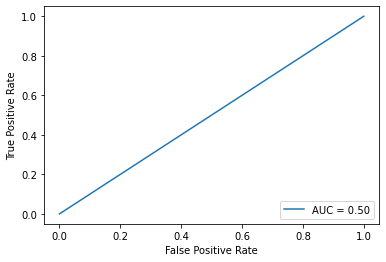

1.161122049527523


In [26]:
print("ROC_AUC Curve for train data")
_,_,t = plot_roc(y_train,train_pred[:,1])
print(max(t))

Threshold=0.000, recall-Score=1.00000
Threshold=0.163, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.27689 
Threshold=0.000, ROC_AUC=0.50000
PR_AUC=0.58035


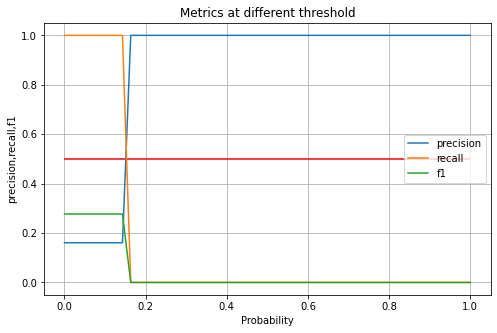

In [27]:
title = "Base Model"
_,_,_,_,_ = threshhold_and_plot(y_train,train_pred[:,1],title,plot=True,isTrain=True)

ROC_AUC Curve for test


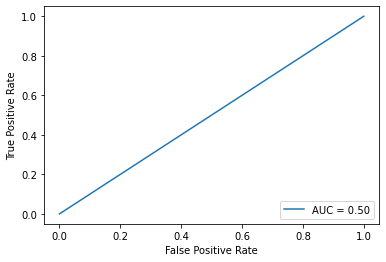

1.161122049527523


In [28]:
print("ROC_AUC Curve for test")
_,_,t = plot_roc(y_test,test_pred[:,1])
print(max(t))

Threshold=0.000, recall-Score=1.00000
Threshold=0.163, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.27672 
Threshold=0.000, ROC_AUC=0.50000
PR_AUC=0.58029


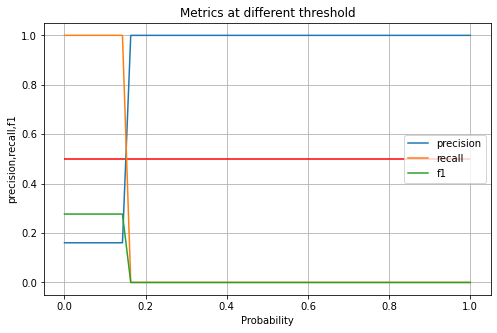

In [29]:
title = "Base Model"
_,_,_,_,_=threshhold_and_plot(y_test,test_pred[:,1],title,plot=True,isTrain=False)

From Random performance on training data, it is evident mimimum performance is seen, as the precision=1, recal and f1 stands 0 scores.And ROC_AUC with 0.5 supports this. 

In [30]:
# same null model with model params, cross validation,
model_params = {"model__C": (np.logspace(start=-4,stop=4,num=30))}
#pipe line has just model object
model_pipeline = pipeline.Pipeline(steps=[("model",null_reg)])
# set up cross-validator:
# 80/20 train/calibration split in this data (test data still held out)
# 200 iterations
cross_validator = (
  model_selection.StratifiedShuffleSplit(train_size=0.8,
                                          random_state=1337,
                                          n_splits=50))
# set up grid search
model_grid = (
  model_selection.GridSearchCV(estimator=model_pipeline,
                           param_grid=model_params,
                           refit=True, # refit using best estimates
                           scoring="roc_auc", # metric to optimize (can pick another)
                           cv=cross_validator,
                           n_jobs = -1))

In [31]:
%%time
# fit model on intercept (random guesses - baseline performance)
null_mod = model_grid.fit(X_train_null,y_train)

Wall time: 3.56 s


In [32]:
%%time
# CV score on null model
cv_recall_scores = (
  model_selection.cross_val_score(null_mod,
                                  X_train_null,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))

Wall time: 1min 49s


In [33]:
cv_quantiles = np.quantile(a=cv_recall_scores,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

 2.5%:0.500,97.5%:0.500


<AxesSubplot:ylabel='Count'>

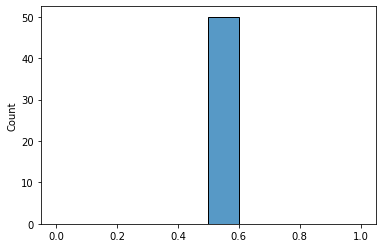

In [34]:
import seaborn as sns
sns.histplot(cv_recall_scores, bins=10)

In [35]:
#check to see if close to population value
print("Observed mean: {:.3f}, Fit: {:.3f}".format(y_test.mean(),test_pred[:,1].mean()))

Observed mean: 0.161, Fit: 0.161


In [36]:
#predict 
null_mod_train_preds = null_mod.predict(X=X_train_null)

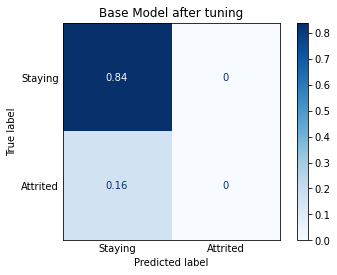

classification report
               precision    recall  f1-score   support

       not 1       0.84      1.00      0.91      5949
           1       1.00      0.00      0.00      1139

    accuracy                           0.84      7088
   macro avg       0.92      0.50      0.46      7088
weighted avg       0.87      0.84      0.77      7088



In [37]:
classifier_name= "Base Model after tuning"
make_matrics_score(y_train,null_mod_train_preds,classifier_name,score=False,y_class_report=True)

ROC_AUC Curve for test


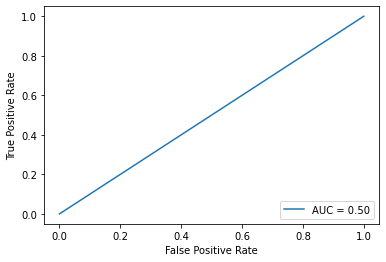

In [38]:
print("ROC_AUC Curve for test")
fpr,tpr,th  = plot_roc(y_train,train_pred[:,1])

Threshold=0.000, recall-Score=1.00000
Threshold=0.163, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.27672 
Threshold=0.000, ROC_AUC=0.50000
PR_AUC=0.58029


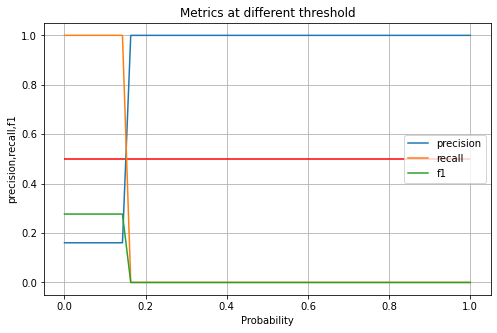

In [39]:
title = "Base Model after tuning"
_,_,_,_,_=threshhold_and_plot(y_test,test_pred[:,1],title,plot=True,isTrain=False)

In [40]:
# get threshold from roc_auc
idx = np.argmax(tpr - fpr)
thresh_null = round(th[idx],4)
null_mod_test_preds = null_mod.predict_proba(X=X_test_null)>thresh_null

In [41]:
#base metrics precision: minimum performance on test data
metrics.precision_score(y_true= y_test,y_pred= np.where(null_mod_test_preds[:,1]>0.5,1,0),zero_division=1)

1.0

In [42]:
#base metrics recall: minmum performance
metrics.recall_score(y_true= y_test,y_pred= np.where(null_mod_test_preds[:,1]>0.5,1,0),zero_division=1)

0.0

In [43]:
#base metrics f1 score: minmum performance
metrics.f1_score(y_true= y_test,y_pred= np.where(null_mod_test_preds[:,1]>0.5,1,0),zero_division=1)

0.0

In [44]:
#check to see if close to population value
print("Observed: {:.3f}, Fit: {:.3f}".format(y_test.mean(),null_mod_test_preds.mean()))

Observed: 0.161, Fit: 0.000


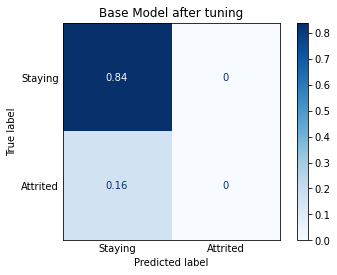

classification report
               precision    recall  f1-score   support

       not 1       0.84      1.00      0.91      2551
           1       1.00      0.00      0.00       488

    accuracy                           0.84      3039
   macro avg       0.92      0.50      0.46      3039
weighted avg       0.87      0.84      0.77      3039



In [45]:
classifier_name= "Base Model after tuning"
make_matrics_score(y_test,null_mod_test_preds[:,1],classifier_name,score=False,y_class_report=True)

ROC_AUC Curve for test


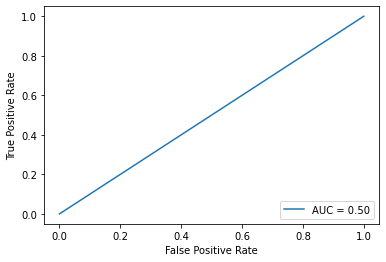

In [46]:
print("ROC_AUC Curve for test")
fpr,tpr,th = plot_roc(y_test,null_mod_test_preds[:,1])

Threshold=0.000, recall-Score=1.00000
Threshold=0.163, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.27672 
Threshold=0.000, ROC_AUC=0.50000
PR_AUC=0.58029


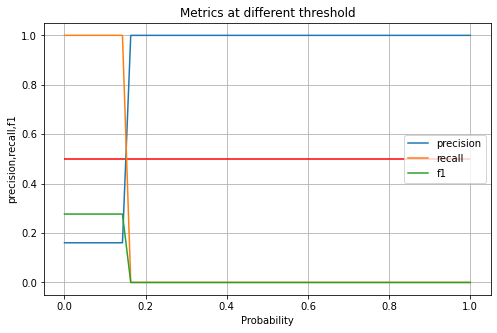

In [47]:
title = "Base Model after tuning"
_,_,_,_,_=threshhold_and_plot(y_test,test_pred[:,1],title,plot=True,isTrain=False)

From Random performance on test data, it is evident mimimum performance is seen, And is supported by ROC_AUC with 0.5.

### Model Selection 

Four competing supervised classfication models/algorithms are considered, namely, 
* Logistic Regression classification
* Random Forest classifier
* KNeighbours classification
* XGBoost classifier 

### Evaluation Metrics

Thinking of customer will not exit but he does, this means income loss for the Bank. Bank need to take the action steps for this scenario. This is false negative, and is "recall". Banks is looking for recall to be maximized, greater the recall lesser the chances of false negative means lesser chances of predicting customers will not exit where in reality they do. Since classes in the data are unbalanced, I can make use of confusion matrix to examine the outcome of model. Recall and precision metrics can be calculated from the confusion matrix, and this would help me assessing the models.

This project is aim to predict potential churn customers, and it is realised that the client cost of mistakenly classifying non-churn customer as churn may be high in practice because banks would not want to lose valuable customers, and the banks would like to identify churners at their best efforts as well. Thus, it would be useful to consider Recall. To complement this Receiver Operating Characteristic curve (ROC) is used. ROC is a plot of True Positive Rate (TPR) against False Positive Rate (FPR). This means I can consider TPR and FPR simultanesouly, by making use of the area under the curve (AUC) of ROC.

### Training and Modeling

Each model is subject to various hyperparameters that need to be determined. Here random search and grid search methods are used optimise the hyperparameters for our chosen models. Grid search exhaustively checks every combinations of hyperparameters given in the parameter domain to optimise the given score, "roc_auc" in this project. Random search checks random combinations of hyperparameters for a given number of iterations to optimise the given score. The advantage of random search is shorter time but the trade-off is that it might miss the best possible combination.

### Hyperparameter Tuning and Model Training

Each model is subject to various hyperparameters that need to be determined. Here random search and grid search methods are used optimise the hyperparameters for our chosen models. Grid search exhaustively checks every combinations of hyperparameters given in the parameter domain to optimise the given score, "roc_auc" in this project. Random search checks random combinations of hyperparameters for a given number of iterations to optimise the given score. The advantage of random search is shorter time but the trade-off is that it might miss the best possible combination.

Below are the two functions, rand_search(), and grid_search(), to help in implementation. No scaling is done as it is each feature is already scaled, so then train the models with training dataset.


In [48]:
# rand search function
def rand_search(X_train,y_train,parameters,model,n_iter=100):
    #pipeline
    clf_pipeline = Pipeline([("clf",model)])
    #Grid search CV
    scoring = 'recall'
    verbose = 1
    clf_rand = model_selection.RandomizedSearchCV(clf_pipeline, parameters, n_iter = n_iter,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1)
    #Learn from training
    clf_rand.fit(X_train,y_train)  #learn the training set
    
    print("Best parameters for ", model) 
    print(clf_rand.best_params_)
    print(f"\nBest train %s score: {clf_rand.best_score_ :.2f}" % (scoring))
    return clf_rand.best_estimator_

In [49]:
# grid search function
def grid_search(X_train,y_train,parameters,model):
    
    #pipeline
    clf_pipeline = Pipeline([("clf",model)])   #Pipeline applies scaling and model estimator
    #Grid search CV
    scoring = 'recall'
    verbose = 1
    clf_grid = model_selection.GridSearchCV(clf_pipeline, parameters,  scoring=scoring,verbose = verbose)
    #Learn from training
    clf_grid.fit(X_train,y_train) 

    print("Best parameters for ", model) 
    print(clf_grid.best_params_)
    print(f"\nBest train %s score: {clf_grid.best_score_ :.2f}" % (scoring))
    return clf_grid.best_estimator_

In [50]:
# converting numby to dataframe 
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Gender_Encoded',
       'Dependent_count', 'Education_Level_sorted', 'Income_Category_sorted',
       'Card_Category_sorted', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
       'Marital_Status_sorted_Married', 'Marital_Status_sorted_Single']
        
#X_train = pd.DataFrame(X_train,columns=cols)
#X_test = pd.DataFrame(X_test,columns=cols)

In [51]:
def estimate_with_threshold(title,estimator,actuals,target,isTrain=False,thresh=1):
    
    y_pred = estimator.predict(actuals)
    y_proba = estimator.predict_proba(actuals)
        
    if isTrain :
        mtitle = title + " on train set"
    else :
        y_proba = (y_proba>=thresh).astype('int')
        mtitle = title + " on test set"
        
    #y_proba = y_proba.astype(int)
    #make confusin matrix
    make_matrics_score(target, y_proba[:,1].astype(int),mtitle,score=True,y_class_report=False)
    
    #Plot Precisn, recall, f1 curve
    threshhold_and_plot(target,y_proba[:,1],title,plot=True,isTrain=isTrain)

    #plot roc_auc
    fpr,tpr,th = plot_roc(target, y_proba[:,1])
    threshold = 1
    if isTrain :
        idx = np.argmax(tpr - fpr)
        threshold = round(th[idx],4)
    
    return threshold

### Logistic Regression

This is the basic regression classification

In this package, there are several hyperparameters that we need to pay attention to:

  C: controls the strength of regularisation penalty
  solver: algorithms used for optimisation
  class_weight: weights associated with classes

In [52]:
#classifier
clf_lg = linear_model.LogisticRegression(fit_intercept= True,max_iter=500,random_state=632966)

# Grid of parameters
model_params_lg = {"model__C": (np.logspace(start=-4,stop=4,num=30)),
                   'model__penalty': ['l2']} 
#'model__solver' : ['liblinear','newton-cg','lbfgs','sag','saga'],

# pipeline
model_pipeline_lg = pipeline.Pipeline(steps=[("model",clf_lg)])

cross_validator = (model_selection.StratifiedShuffleSplit(train_size=0.8,random_state=1337,n_splits=50))

# set up grid search
model_grid_lg = (
  model_selection.GridSearchCV(estimator=model_pipeline_lg,
                               param_grid=model_params_lg,
                               refit=True, # refit using best estimates
                               scoring="recall", cv=cross_validator,n_jobs = -1,verbose=1))

In [53]:
%%time
lg_mod = model_grid_lg.fit(X_train,y_train)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Wall time: 25.3 s


In [54]:
log_best_estimator = lg_mod.best_estimator_
log_best_estimator

Pipeline(steps=[('model',
                 LogisticRegression(C=17.433288221999874, max_iter=500,
                                    random_state=632966))])

In [55]:
print(f"Best params {lg_mod.best_params_} \nBest score {lg_mod.best_score_ }")

Best params {'model__C': 17.433288221999874, 'model__penalty': 'l2'} 
Best score 0.37131578947368415


In [56]:
#cross validation
lr_cv_scores = (
    model_selection.cross_val_score(log_best_estimator,
                                      X_train,
                                      y_train,
                                      scoring="roc_auc",
                                      cv=cross_validator,
                                      n_jobs=-1))

In [57]:
cv_quantiles = np.quantile(a=lr_cv_scores,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{lr_cv_scores.mean():.3f}")

 Performance on training set is in range between 0.799 to 0.854,with average roc_auc:0.826


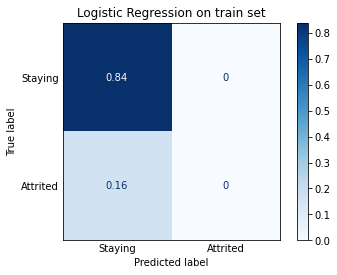

True -ve : 0.84
False +ve : 0.0
False -ve : 0.16
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=0.959, precision-Score=1.00000 
Threshold=0.306, f1-Score=0.56379 
Threshold=0.306, ROC_AUC=0.74033
PR_AUC=0.60742


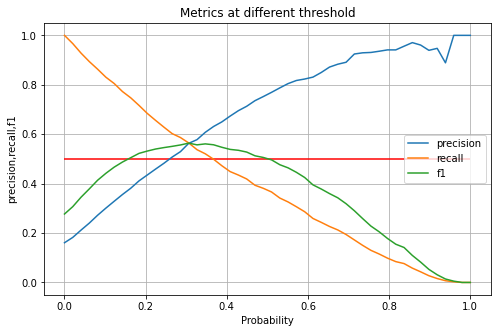

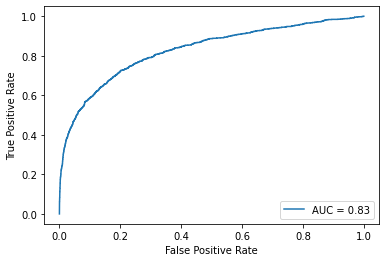

In [58]:
thresh = estimate_with_threshold("Logistic Regression",log_best_estimator,X_train,y_train,isTrain=True)

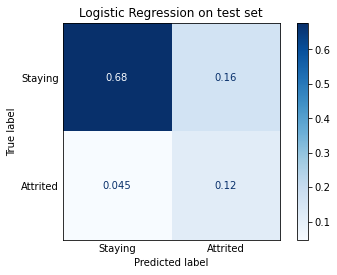

True -ve : 0.68
False +ve : 0.16
False -ve : 0.05
True +ve : 0.12

Threshold=0.000, recall-Score=0.71721
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.52592 
Threshold=0.000, ROC_AUC=0.76198
PR_AUC=0.50749


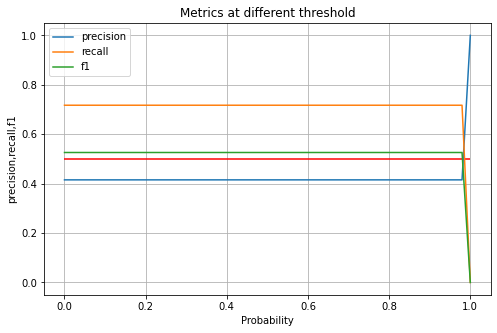

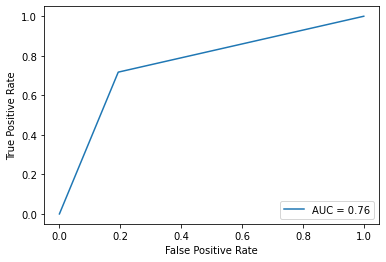

In [59]:
_ = estimate_with_threshold("Logistic Regression",log_best_estimator,X_test,y_test,isTrain=False,thresh = thresh)

In [60]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.00000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.56453,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494


This is an imbalanced dataset .A problem with imbalanced classification is that there are too few examples of the minority class for a model to effectively learn the decision boundary.

One way to solve this problem is to oversample the examples in the minority class. This can be achieved by simply duplicating examples from the minority class in the training dataset prior to fitting a model. This can balance the class distribution but does not provide any additional information to the model.One approach to addressing imbalanced datasets is to oversample the minority class. The simplest approach involves duplicating examples in the minority class, although these examples don’t add any new information to the model. Instead, new examples can be synthesized from the existing examples. This is a type of data augmentation for the minority class and is referred to as the Synthetic Minority Oversampling Technique, or SMOTE for short.

Since dataset is imbalanced let try oversampling using SMOTE and see if performance can be improved.


In [61]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   #Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


In [62]:
%%time
#fitting the model after SMOTE
lg_mod_over = model_grid_lg.fit(X_train_over,y_train_over)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Wall time: 31.4 s


In [63]:
logOver_best_estimator = lg_mod_over.best_estimator_

In [64]:
#cross validation
lr_cv_scores = (
    model_selection.cross_val_score(logOver_best_estimator ,
                                      X_train_over,
                                      y_train_over,
                                      scoring="roc_auc",
                                      cv=cross_validator,
                                      n_jobs=-1))

In [65]:
cv_quantiles = np.quantile(a=lr_cv_scores,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{lr_cv_scores.mean():.3f}")

 Performance on training set is in range between 0.834 to 0.858,with average roc_auc:0.844


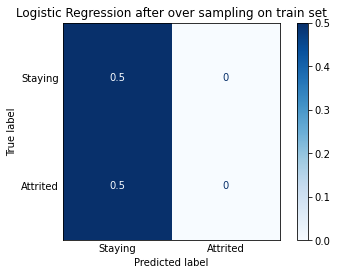

True -ve : 0.5
False +ve : 0.0
False -ve : 0.5
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=1.000, precision-Score=1.00000 
Threshold=0.408, f1-Score=0.77141 
Threshold=0.408, ROC_AUC=0.75408
PR_AUC=0.85251


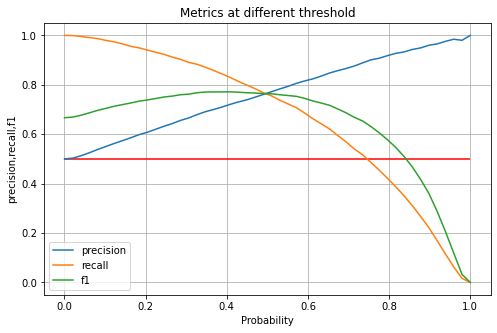

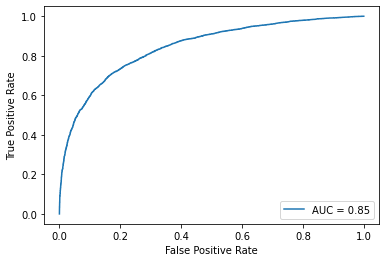

In [66]:
thresh = estimate_with_threshold("Logistic Regression after over sampling",logOver_best_estimator,X_train_over,y_train_over,isTrain=True)

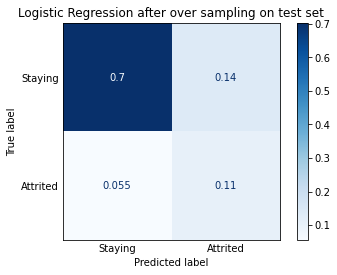

True -ve : 0.7
False +ve : 0.14
False -ve : 0.05
True +ve : 0.11

Threshold=0.000, recall-Score=0.65984
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.52529 
Threshold=0.000, ROC_AUC=0.74838
PR_AUC=0.47387


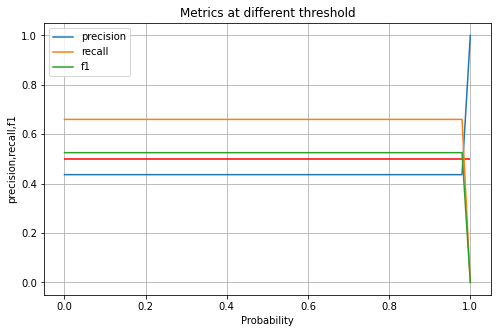

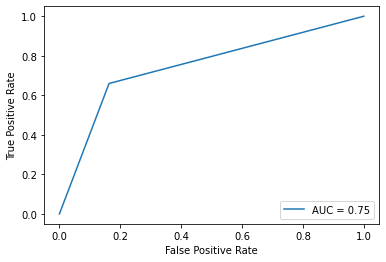

In [67]:
_ = estimate_with_threshold("Logistic Regression after over sampling",logOver_best_estimator,X_test,y_test,isTrain=False,thresh = thresh)

In [68]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866


Logistic Regression showed recall rate only .56 on train and on test 0.71. so are the other score. May be because of imbalanced data it is overfitting. This is visible on scores between train and test. After over sampling train recall is improved to 0.83 and however on test is 0.28. so are the other scores. on test is poor performance, lot of discrepancy in score between train and set.and is overfitting.I need to try under fitting now. 

In [69]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 1) # Undersample dependent variable
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [70]:
%%time
lg_mod_under = model_grid_lg.fit(X_train_over,y_train_over)

Fitting 50 folds for each of 30 candidates, totalling 1500 fits
Wall time: 30.9 s


In [71]:
logUnder_best_estimator = lg_mod_over.best_estimator_

In [72]:
#cross validation
lr_cv_scores_under = (
    model_selection.cross_val_score(logUnder_best_estimator ,
                                      X_train_over,
                                      y_train_over,
                                      scoring="roc_auc",
                                      cv=cross_validator,
                                      n_jobs=-1))

In [73]:
cv_quantiles = np.quantile(a=lr_cv_scores_under,q=[0.025,0.975])
print(f" Performance on training set is in range between {cv_quantiles[0]:.3f} to {cv_quantiles[1]:.3f},with average roc_auc:{lr_cv_scores.mean():.3f}")

 Performance on training set is in range between 0.834 to 0.858,with average roc_auc:0.844


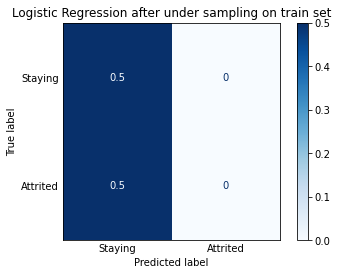

True -ve : 0.5
False +ve : 0.0
False -ve : 0.5
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=1.000, precision-Score=1.00000 
Threshold=0.408, f1-Score=0.77141 
Threshold=0.408, ROC_AUC=0.75408
PR_AUC=0.85251


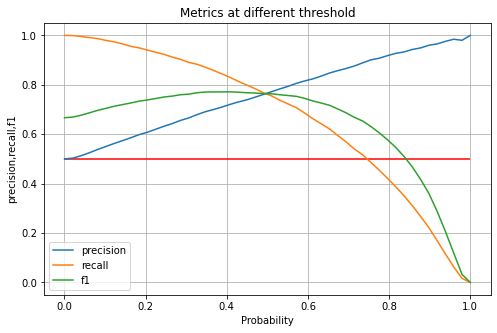

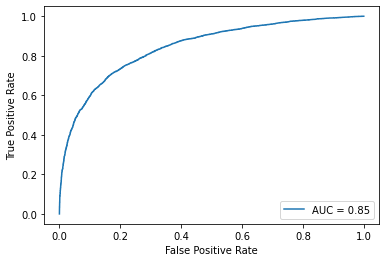

In [74]:
thresh = estimate_with_threshold("Logistic Regression after under sampling",logUnder_best_estimator,X_train_over,y_train_over,isTrain=True)

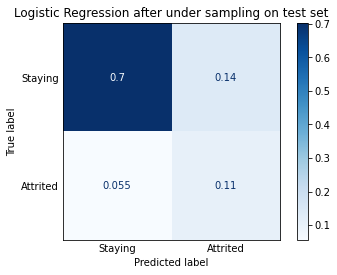

True -ve : 0.7
False +ve : 0.14
False -ve : 0.05
True +ve : 0.11

Threshold=0.000, recall-Score=0.65984
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.52529 
Threshold=0.000, ROC_AUC=0.74838
PR_AUC=0.47387


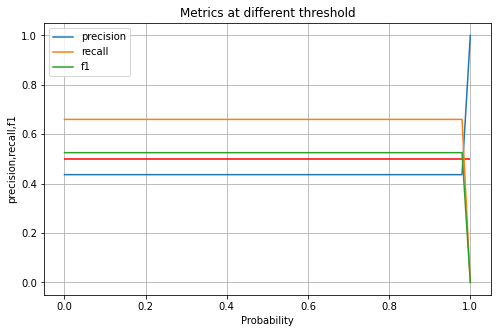

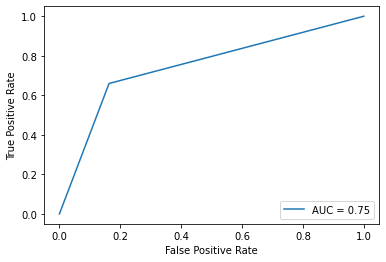

In [75]:
_ = estimate_with_threshold("Logistic Regression after under sampling",logUnder_best_estimator,X_test,y_test,isTrain=False,thresh = thresh)

In [76]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Logistic Regression after under sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866


After undersmapling test scores are slightly improved, however it is not good between train and test, it is still overfitting.

### Random Forest Classification

Random Forest consists of an ensemble of decision trees. The algorithm splits the dataset into independent random subsamples and selects subsamples of features, and fits a decision tree classfier to each subsample. It then averages the estimates to improve the prediction accuracy.

We will use the class sklearn.ensemble.RandomForestClassifier from scikit learn. Based on our research, there are several hyperparameters that we will need to adjust:

  n_estimator: the number of trees in the forest
  min_samples_split:the minimum number of data points required to be at a leaf node
  max_features: the number of features to consider when looking for the best split
  max_depth: the maximum depth of the tree

In [77]:
#Setting ranges for each parameter.
clf__max_depth = [int(x) for x in np.linspace(5, 50, num = 10)]
rfc_params = {"clf__n_estimators": np.linspace(start = 100, stop = 1000, num = 10,dtype=int),
              "clf__min_samples_split": np.arange(2,6), 
              "clf__max_features":["sqrt", "log2"],
              "clf__max_depth": clf__max_depth
             }

In [78]:
%%time
classifier=ensemble.RandomForestClassifier(random_state=1,n_jobs=-1)
rfc_best_estimator = rand_search(X_train,y_train, rfc_params, classifier,n_iter=120) #apply random search

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  RandomForestClassifier(n_jobs=-1, random_state=1)
{'clf__n_estimators': 1000, 'clf__min_samples_split': 3, 'clf__max_features': 'log2', 'clf__max_depth': 50}

Best train recall score: 0.71
Wall time: 8min 8s


### KNeighbours Classification

KNeighbours classfication chooses K nearest data points to the unlabeled data point then ask the K neighbours to "vote" for the classes that the point belongs to.

We will use the class sklearn.neighbors.KNeighborsClassifier for the implementation. Important hyperparameters that we will adjust are shown as follows:

  n_neighbors: the number of closest neigbours
  weights: weight function in prediction
  p: Power parameter for the Minkowski metric. When p = 1, this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2

In [79]:
#Setting ranges for the hyperparameters are shown below.
knn_params = {"clf__n_neighbors":[2,5,10,87,100],
              "clf__weights":["uniform", "distance"],
              "clf__p":[1,2] 
             }

In [80]:
%time
classifier = neighbors.KNeighborsClassifier(n_jobs=-1)
knn_best_estimator = grid_search(X_train,y_train, knn_params, classifier)

Wall time: 0 ns
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters for  KNeighborsClassifier(n_jobs=-1)
{'clf__n_neighbors': 2, 'clf__p': 1, 'clf__weights': 'distance'}

Best train recall score: 0.41


### XGBoost Classification

XGBoost uses gradient boosting technique, and is on the priciples of decison tree ensemble, which a set of classification and regression trees. It is similar to Random Forest difference is how the algorithms train the models.

The hyperparameters we need to fine-tune are as follows:

  learning_rate: the learning rate of gradient boosting
  max_depth:maximum tree depth
  min_child_weight: minimum sum of instance weight(hessian) needed in a child. Useful to reduce overfitting
  reg_lambda: L2 regularisation

In [81]:
#Settingranges for the hyperparameter are shown below.
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }

In [82]:
%%time
classifier = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

xgb_best_estimator = rand_search(X_train,y_train, xgb_params,classifier,n_iter=120)

Fitting 5 folds for each of 120 candidates, totalling 600 fits
Best parameters for  XGBClassifier(base_score=None, booster='gbtree', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=None, reg_alpha=None,
              reg_lambda=None, scale_pos_weight=None, subsample=None,
              tree_method=None, use_label_encoder=False,
              validate_parameters=None, verbosity=0)
{'clf__reg_lambda': 0.9, 'clf__min_child_weight': 3, 'clf__max_depth': 5, 'clf__learning_rate': 0.4}

Best train recall score: 0.78
Wall time: 1min 46s


### Evaluation

Now run the model using the best estimators on the train and train set, and print out the confusion matrix and evaluation metrics.

### Logistic Regression

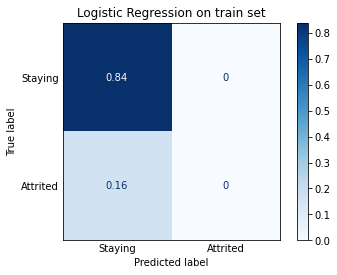

True -ve : 0.84
False +ve : 0.0
False -ve : 0.16
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=0.959, precision-Score=1.00000 
Threshold=0.306, f1-Score=0.56379 
Threshold=0.306, ROC_AUC=0.74033
PR_AUC=0.60742


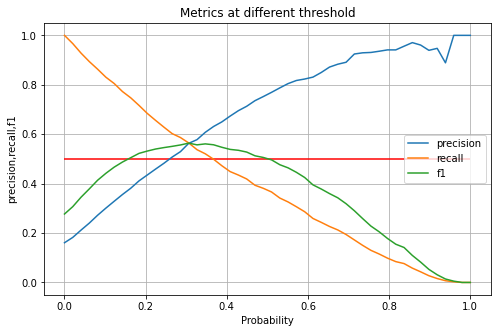

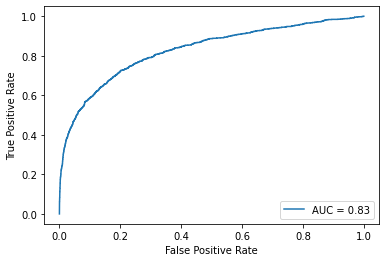

In [83]:
#on train set
thr = estimate_with_threshold("Logistic Regression",log_best_estimator,X_train,y_train,isTrain=True)

In [84]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Logistic Regression after under sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866


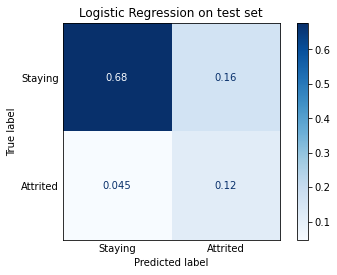

True -ve : 0.68
False +ve : 0.16
False -ve : 0.05
True +ve : 0.12

Threshold=0.000, recall-Score=0.71721
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.52592 
Threshold=0.000, ROC_AUC=0.76198
PR_AUC=0.50749


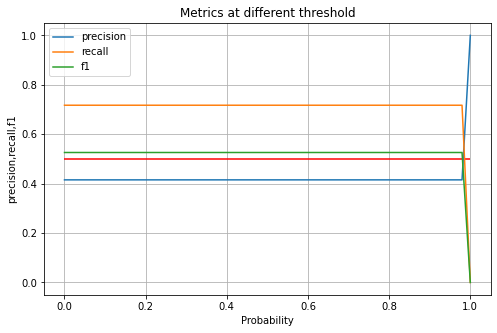

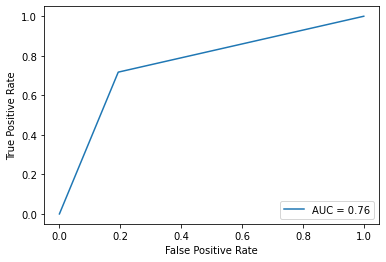

In [85]:
#on test set
_ = estimate_with_threshold("Logistic Regression",log_best_estimator,X_test,y_test,isTrain=False,thresh = thr)

In [86]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Logistic Regression after under sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866


### Random Forest Classification

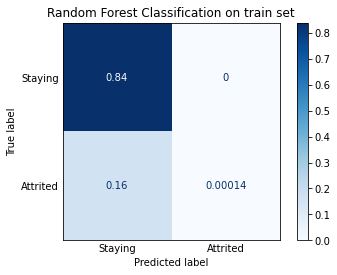

True -ve : 0.84
False +ve : 0.0
False -ve : 0.16
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=0.469, precision-Score=1.00000 
Threshold=0.469, f1-Score=1.00000 
Threshold=0.469, ROC_AUC=1.00000
PR_AUC=1.00000


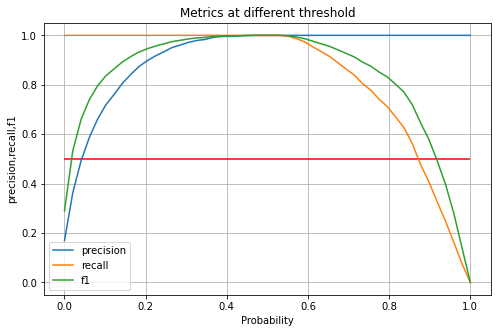

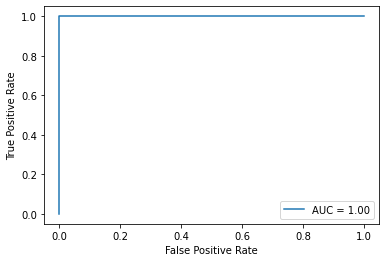

In [87]:
#on train set
thr = estimate_with_threshold("Random Forest Classification",rfc_best_estimator,X_train,y_train,isTrain=True)

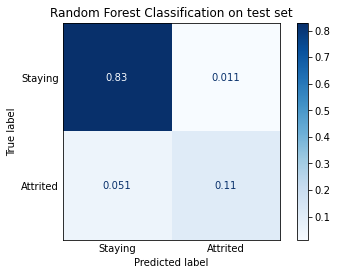

True -ve : 0.83
False +ve : 0.01
False -ve : 0.05
True +ve : 0.11

Threshold=0.000, recall-Score=0.68238
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.78077 
Threshold=0.000, ROC_AUC=0.83492
PR_AUC=0.65246


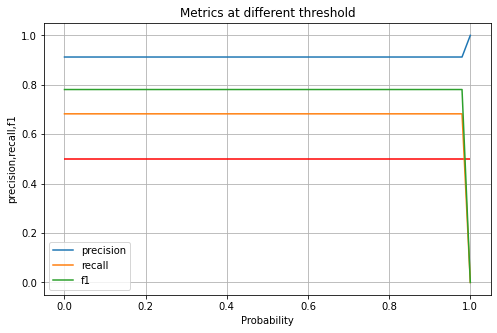

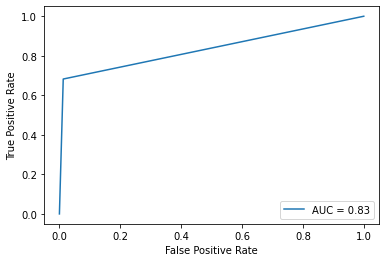

In [88]:
#on test set
_ = estimate_with_threshold("Random Forest Classification",rfc_best_estimator,X_test,y_test,isTrain=False,thresh = thr)

### KNeighbours Classification

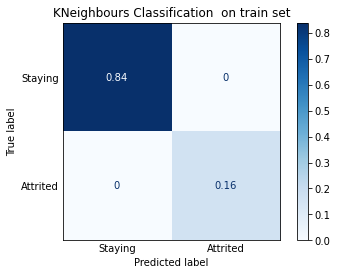

True -ve : 0.84
False +ve : 0.0
False -ve : 0.0
True +ve : 0.16

Threshold=0.000, recall-Score=1.00000
Threshold=0.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=1.00000 
Threshold=0.000, ROC_AUC=1.00000
PR_AUC=1.00000


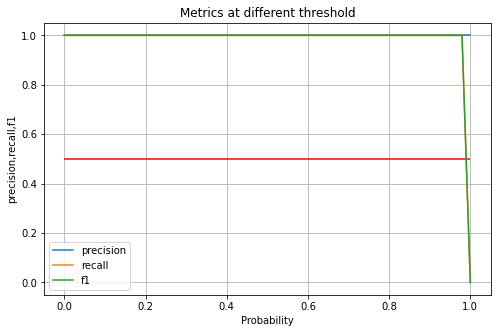

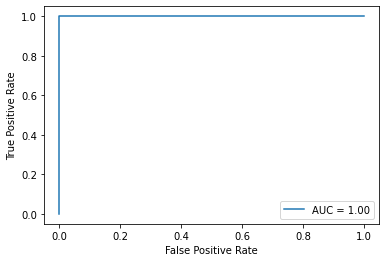

In [89]:
#on train set
thr = estimate_with_threshold("KNeighbours Classification ",knn_best_estimator,X_train,y_train,isTrain=True)

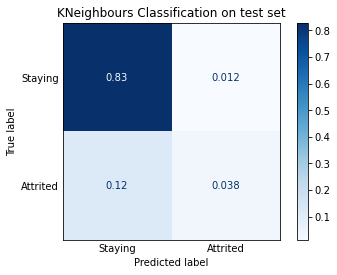

True -ve : 0.83
False +ve : 0.01
False -ve : 0.12
True +ve : 0.04

Threshold=0.000, recall-Score=0.23361
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.35793 
Threshold=0.000, ROC_AUC=0.60994
PR_AUC=0.20617


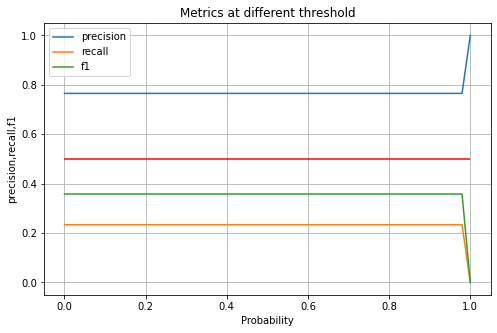

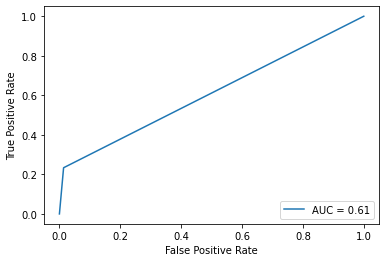

In [90]:
#on test set
_ = estimate_with_threshold("KNeighbours Classification",knn_best_estimator,X_test,y_test,isTrain=False,thresh = thr)

In [91]:
evaluation

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Logistic Regression after under sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Random Forest Classification,1.000000,1.000000,1.000000,1.000000,1.000000,0.682377,0.912329,0.780774,0.834916,0.652465
KNeighbours Classification,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN
KNeighbours Classification,NaN,NaN,NaN,NaN,NaN,0.233607,0.765101,0.357928,0.609943,0.206170


### XGBoost Classification

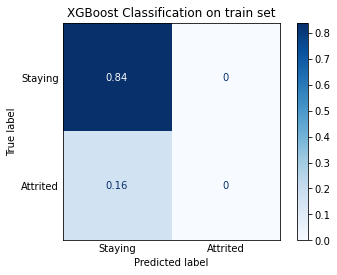

True -ve : 0.84
False +ve : 0.0
False -ve : 0.16
True +ve : 0.0

Threshold=0.000, recall-Score=1.00000
Threshold=0.735, precision-Score=1.00000 
Threshold=0.449, f1-Score=0.98068 
Threshold=0.449, ROC_AUC=0.98849
PR_AUC=0.99838


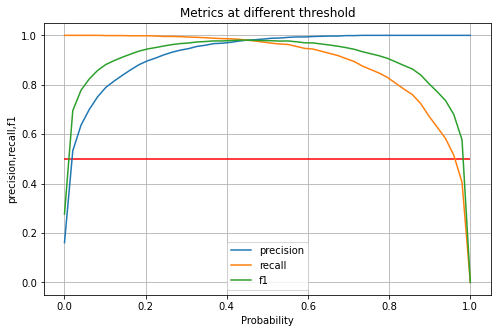

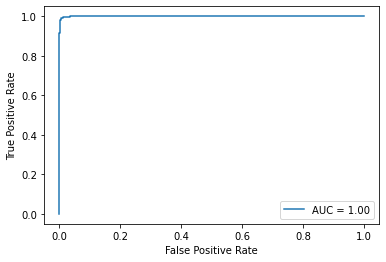

In [92]:
#on train set
thr = estimate_with_threshold("XGBoost Classification",xgb_best_estimator,X_train,y_train,isTrain=True)

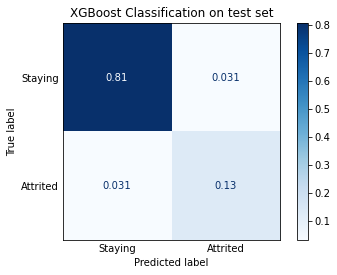

True -ve : 0.81
False +ve : 0.03
False -ve : 0.03
True +ve : 0.13

Threshold=0.000, recall-Score=0.80943
Threshold=1.000, precision-Score=1.00000 
Threshold=0.000, f1-Score=0.80777 
Threshold=0.000, ROC_AUC=0.88609
PR_AUC=0.73096


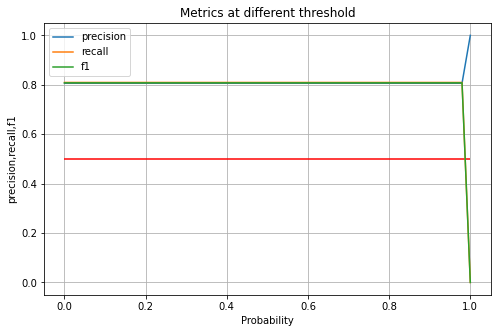

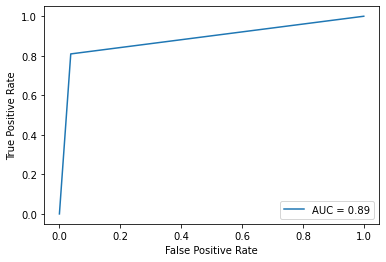

In [93]:
#on test set
_ = estimate_with_threshold("XGBoost Classification",xgb_best_estimator,X_test,y_test,isTrain=False,thresh = thr)

### Metrics Comparision

In [95]:
evaluation.sort_values(by ='Test_ROC_AUC', ascending = False)

,Train_Recall,Train_Precision,Train_F1,Train_ROC_AUC,Train_PR_score,Test_Recall,Test_Precision,Test_F1,Test_ROC_AUC,Test_PR_score
XGBoost Classification,0.980685,0.980685,0.980685,0.988493,0.998379,0.809426,0.806122,0.807771,0.886093,0.730961
Random Forest Classification,1.000000,1.000000,1.000000,1.000000,1.000000,0.682377,0.912329,0.780774,0.834916,0.652465
Logistic Regression,0.564530,0.563047,0.563788,0.740325,0.607421,0.717213,0.415184,0.525920,0.761978,0.507494
Logistic Regression after over sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
Logistic Regression after under sampling,0.829887,0.720625,0.771406,0.754076,0.852509,0.659836,0.436314,0.525285,0.748381,0.473866
KNeighbours Classification,NaN,NaN,NaN,NaN,NaN,0.233607,0.765101,0.357928,0.609943,0.206170
Base Model,1.000000,0.160694,0.276893,0.500000,0.580347,1.000000,0.160579,0.276722,0.500000,0.580290
Base Model after tuning,NaN,NaN,NaN,NaN,NaN,1.000000,0.160579,0.276722,0.500000,0.580290
KNeighbours Classification,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN


* XGBoost classifier leads in both test and train AUC_ROC. and with Accuracy as well.The model can 85% time accuractely predict potential customers who could churn.
* Kneighbor performed the least on test set, but well on train set.
* logistic regression performed least on Trrain set interms of recall 0.96. All other model performed well on train set for recall.


### ROC_AUC Curve Comparison

In [100]:
def calc_threshold(tpr,fpr,thresholds,clf_name):
    
    # locate the index
    idx = np.argmax(tpr - fpr)
    #find the threshold at max index
    max_threshold = round(thresholds[idx],4)
    print('Best Threshold for {0}={1} and index={2}'.format(clf_name,thresholds[idx], idx))
    roc_auc = round(metrics.auc(fpr, tpr),4)
    return idx,roc_auc

In [97]:
from numpy import sqrt
from numpy import argmax
def ROC_AUC_Comparison(X_data,y_data):

    y_proba_knn = knn_best_estimator.predict_proba(X_data)
    y_proba_rfc = rfc_best_estimator.predict_proba(X_data)
    y_proba_xgb = xgb_best_estimator.predict_proba(X_data)
    y_scores_log = log_best_estimator.decision_function(X_data)

    fpr_knn, tpr_knn, knn_thresholds = metrics.roc_curve(y_data, y_proba_knn[:,1])
    fpr_rfc, tpr_rfc, rfc_thresholds = metrics.roc_curve(y_data, y_proba_rfc[:,1])
    fpr_xgb, tpr_xgb, xgb_thresholds = metrics.roc_curve(y_data, y_proba_xgb[:,1])
    fpr_log, tpr_log, log_thresholds = metrics.roc_curve(y_data, y_scores_log)

    plt.figure(figsize=(8,8))
    plt.xlim([-0.01, 1.00])
    plt.ylim([-0.01, 1.01])
    plt.plot([0,1], [0,1], linestyle='--')

    ix,roc_auc = calc_threshold(tpr_knn,fpr_knn,knn_thresholds,'KNeighbors')
    plt.plot(fpr_knn, tpr_knn, lw=1,label='KNeighbors: roc_auc - {0}'.format(roc_auc), color='blue')
    plt.scatter(fpr_knn[ix], tpr_knn[ix], marker='o', color='blue')

    ix,roc_auc = calc_threshold(tpr_rfc,fpr_rfc,rfc_thresholds,'RandForest')
    plt.plot(fpr_rfc, tpr_rfc, lw=1, label=('RandForest: roc_auc - {0}'.format(roc_auc)), color='orange')
    plt.scatter(fpr_rfc[ix], tpr_rfc[ix], marker='o', color='orange')

    xgb_thresholds=np.float64(xgb_thresholds)
    ix,roc_auc = calc_threshold(tpr_xgb,fpr_xgb,xgb_thresholds,'XGBoost')
    plt.plot(fpr_xgb, tpr_xgb, lw=1, label=('XGBoost: roc_auc - {0}'.format(roc_auc)), color='yellow')
    plt.scatter(fpr_xgb[ix], tpr_xgb[ix], marker='o', color='yellow')

    ix,roc_auc = calc_threshold(tpr_log,fpr_log,log_thresholds,'LogRegr')
    plt.plot(fpr_log, tpr_log, lw=1, label=('LogRegr: roc_auc - {0}'.format(roc_auc)), color='red')
    plt.scatter(fpr_log[ix], tpr_log[ix], marker='o', color='red')

    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.title('ROC curve o', fontsize=16)
    plt.legend(loc='lower right', fontsize=13)

    plt.show();

Best Threshold for KNeighbors=1.0 and index=1
Best Threshold for RandForest=0.5314000000000001 and index=24
Best Threshold for XGBoost=0.3404558300971985 and index=58
Best Threshold for LogRegr=-1.5148960942589405 and index=782


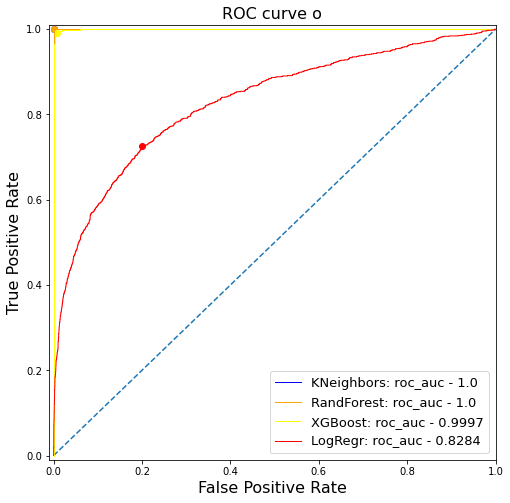

In [98]:
## ROC_AUC Comparison on Train set
ROC_AUC_Comparison(X_train,y_train)

On train data Kneighbors and Randomforest has perfect 1.0. Followed with Xgboost 0.99

Best Threshold for KNeighbors=0.37335609928915464 and index=191
Best Threshold for RandForest=0.2319333333333333 and index=184
Best Threshold for XGBoost=0.07169295847415924 and index=184
Best Threshold for LogRegr=-1.4881254728291626 and index=324


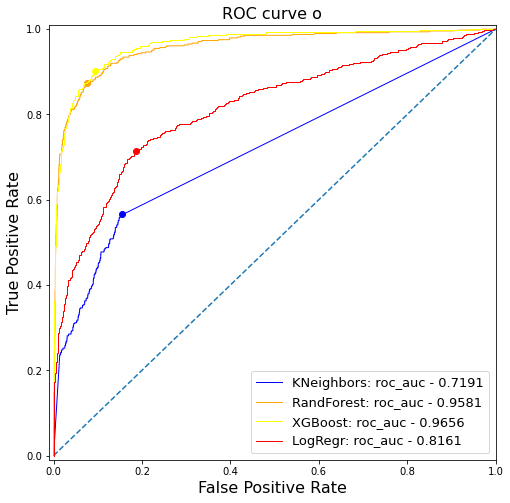

In [99]:
##ROC_AUC Comparison on Test set
ROC_AUC_Comparison(X_test,y_test)

XGBoost tops with roc_auc 0.97, followed by Random Forest with 0.96

With this it can be concluded XGBoost can perform well among all selected model on these kind of data.so it is safe to select XGB classifier for further steps.
Let me move with feature imporatnce on XGBoost classifier.

### Feature Importance

Feature Importance is a process used to select features in the dataset that contributes the most in predicting the target variable. Working with selected features instead of all the features reduces the risk of over-fitting, improves accuracy, and decreases the training time. 

Finding Feature importance and selecting top 8 features

In [ ]:
# converting numby to dataframe 
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Gender_Encoded',
       'Dependent_count', 'Education_Level_sorted', 'Income_Category_sorted',
       'Card_Category_sorted', 'Months_on_book', 'Total_Relationship_Count',
       'Months_Inactive_12_mon', 'Contacts_Count_12_mon',
       'Marital_Status_sorted_Married', 'Marital_Status_sorted_Single']
        
X_train = pd.DataFrame(X_train,columns=cols)
X_test = pd.DataFrame(X_test,columns=cols)

Many ways to find the feature importance, I am using builtin XBG function

In [ ]:
#find top 8 feature using XGBoost

from xgboost import XGBRegressor,plot_importance
import matplotlib.pyplot as plt
#xgb = XGBRegressor(n_estimators=100)
xgb = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)
xgb.fit(X_train, y_train)

# from Builtin XGB
plot_importance(xgb, max_num_features = 10,height=0.5)
plt.figure(figsize=(20,20))
plt.show()

The top 8 features can influence prediction are as below. 

* Total_Trans_Amt: Total Transaction Amount in Last 12 months((one year))
* Credit_Limit: Credit Limit on the Credit Card
* Customer_Age: Age in Years
* Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
* Avg_Utilization_Ratio: Represents how much of the available credit the customer spent
* Total_Relationship_Count: Total no. of products held by the customer
* Contacts_Count_12_mon: No. of Contacts between the customer and bank in the last 12 months(one year)
* Months_Inactive_12_mon: No. of months inactive in the last 12 months(one year)

In [ ]:
# creating train, test for these 8 features
'''cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio', 'Total_Relationship_Count',
        'Contacts_Count_12_mon','Months_Inactive_12_mon']
'''

# using only top 5 , patsy is crashing my PC
cols = ['Customer_Age', 'Credit_Limit', 'Total_Revolving_Bal',
       'Total_Trans_Amt', 'Avg_Utilization_Ratio']

X_train_f = pd.DataFrame(X_train,columns=cols)
X_test_f = pd.DataFrame(X_test,columns=cols)

### Feature interactions

For this purpose I am using python package called 'patsy'. And here is the intoduction and references.

Feature interaction using design Matrix. The design matrix contains data on the independent variables (also called explanatory variables) in statistical models which attempt to explain observed data on a response variable (often called a dependent variable) in terms of the explanatory variables. The theory relating to such models makes substantial use of matrix manipulations involving the design matrix: see for example linear regression. A notable feature of the concept of a design matrix is that it is able to represent a number of different experimental designs and statistical models, e.g., ANOVA, ANCOVA, and linear regression.[ ref: https://en.wikipedia.org/wiki/Design_matrix

<b>ref:</b>
* https://learn-scikit.oneoffcoder.com/patsy.html
* https://learn-scikit.oneoffcoder.com/xgboost.html
* https://readthedocs.org/projects/patsy/downloads/pdf/latest/
* https://www.programcreek.com/python/example/120751/patsy.dmatrix

patsy is a Python package for describing statistical models (especially linear models, or models that have a linear component) and building design matrices. It is closely inspired by and compatible with the formula mini-language used in R and S. For instance, if we have some variable y, and we want to regress it against some other variables x, a, b, and the interaction of a and b, then we simply write: patsy.dmatrices("y ~ x + a + b + a:b", data) and Patsy takes care of building appropriate matrices.
ref: https://patsy.readthedocs.io/en/latest/overview.html

Patsy is a neat API to transform your data into experimentation model form. For regression and classification problems, you often want your data in the Xy form where X is a matrix (independent variable) and y is a column vector (dependent variable).
ref: https://learn-scikit.oneoffcoder.com/patsy.html


In [ ]:
from patsy import dmatrix
#formula = 'Customer_Age*Credit_Limit*Total_Revolving_Bal*Total_Trans_Amt*Avg_Utilization_Ratio*Total_Relationship_Count*Contacts_Count_12_mon*Months_Inactive_12_mon'
# only top 5 is used.
#create model formula
model_formula = 'Total_Trans_Amt*Credit_Limit*Customer_Age*Total_Revolving_Bal*Avg_Utilization_Ratio'
#Apply model formula to train and test
X_train = dmatrix(model_formula, X_train_f, return_type='dataframe')
X_test = dmatrix(model_formula, X_test_f, return_type='dataframe')

In [ ]:
X_train.head(5)

In [ ]:
X_test.head(5)

### Hyperparameter Tuning and Model Training

In [ ]:
%time
clf_XGB = XGBClassifier(booster="gbtree", verbosity=0, use_label_encoder=False,n_jobs=-1)

#pipeline
clf_pipeline = Pipeline([("clf",clf_XGB)])   

#setting params
xgb_params = {"clf__learning_rate": [0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
               "clf__max_depth": np.arange(2,7),
               "clf__min_child_weight": np.arange(1,11),
               "clf__reg_lambda": np.linspace(0.1,1,num=10)
              }
#Random search 
scoring = 'roc_auc'
verbose = 1
clf_XGBoost = model_selection.RandomizedSearchCV(clf_pipeline, xgb_params, n_iter = 120,scoring=scoring,verbose = verbose, random_state=1,n_jobs=-1) 
       

In [ ]:
%%time
#learn the training set
clf_XGBoost.fit(X_train,y_train)

In [ ]:
print("Best parameters for XGBoost") 
print(clf_XGBoost.best_params_)
print(f"\nBest train %s score: {clf_XGBoost.best_score_ :.2f}" % (scoring))
print(f"\nBest estimator: {clf_XGBoost.best_estimator_}") 

In [ ]:
# i could not comeplete this my system is crashing, after applying dmarix. so moving on to next step.
cv_scores_XGB = (
  model_selection.cross_val_score(clf_XGBoost,
                                  X_train,
                                  y_train,
                                  scoring="roc_auc",
                                  cv=cross_validator,
                                  n_jobs=-1))



In [ ]:
cv_quantiles = np.quantile(a=cv_scores_lg,q=[0.025,0.975])
print(f" 2.5%:{cv_quantiles[0]:.3f},97.5%:{cv_quantiles[1]:.3f}")

In [ ]:
sns.set_style("darkgrid")
sns.histplot(cv_scores_lg, bins=10)

In [ ]:
max_thresh(cv_scores_XGB)

In [ ]:
# taking threshod value from earlier estimation with XGB, it is found 0.91
t=0.91
y_train_predXGB = clf_XGBoost.best_estimator_.predict(X_train)
y_train_probaXGB = clf_XGBoost.best_estimator_.predict_proba(X_train)
y_train_probaXGB = (y_train_probaXGB >=t).astype('int')

In [ ]:
classifier_name= "XGBoost after feature interaction"
make_matrics_score(y_train,y_train_predXGB,classifier_name,score=False,y_class_report=False,isTrain = True)

In [ ]:
#train data, precsion,recall
_,r,_ = threshhold_and_plot(y_train,y_train_predXGB,plot=True)
max_recall_train_idx, max_recall_train_val = max_thresh(r)
print("Max Test recall - {} at index {}".format(max_recall_train_val,max_recall_train_idx))

In [ ]:
#presicion recall curve
plot_precision_recall_curve(y_train,y_train_probaXGB[:,1])

In [ ]:
t=0.91
y_test_predXGB = clf_XGBoost.best_estimator_.predict(X_test)
y_test_probaXGB = clf_XGBoost.best_estimator_.predict_proba(X_test)
y_test_probaXGB = (y_test_probaXGB >=t).astype('int')

In [ ]:
_,r,_=threshhold_and_plot(y_test,y_test_probaXGB[:,1],n_points=50,plot=True)

In [ ]:
max_thresh(r)

In [ ]:
_,_,_=plot_roc(y_test,y_test_probaXGB[:,1])

In [ ]:
plot_precision_recall_curve(y_test,y_test_probaXGB[:,1])

In [ ]:
estimate_with_threshold(classifier_name,clf_XGBoost.best_estimator_4,X_test,y_test,isTrain=False)

### Evaluation

Now run the model using the best estimators on the test set, and print out the confusion matrix and evaluation metrics.

In [ ]:
_ = estimate_with_threshold("XGBoost with feature interaction",xgb_best_estimator,X_test,y_test,isTrain=False)

### ROC Curve 

XGBoost is performed well with AUC 95%. At production this model can be deployed to predict customer churns or not.

Random Forest is the nest classifier on these kind of data set. This means, ensemble and boosting algo work on these type of dataset.

### At production

In [ ]:
thr = estimate_with_threshold("XGBoost with feature interaction",xgb_best_estimator,X_train,y_train,isTrain=True)

In [ ]:
y_proba_xgb = xgb_best_estimator.predict_proba(X_test)

fpr_xgb, tpr_xgb, xgb_thresholds = metrics.roc_curve(y_test, y_proba_xgb[:,1])

# null ROC AUC
plt.figure(figsize=(5,5))
plt.xlim([-0.01, 1.00])
plt.ylim([-0.01, 1.01])
plt.plot([0,1], [0,1], linestyle='--')

# Calculate bestthreshold from ROC AUC
xgb_thresholds=np.float64(xgb_thresholds)
idx = np.argmax(tpr_xgb - fpr_xgb)
max_threshold = round(xgb_thresholds[idx],4)
roc_auc = round(metrics.auc(fpr_xgb, tpr_xgb),4)
print('Best Threshold is',max_threshold)

#idx,roc_auc = calc_threshold(tpr_xgb,fpr_xgb,xgb_thresholds,'XGBoost')
plt.plot(fpr_xgb, tpr_xgb, lw=1, label=('XGBoost: roc_auc - {0}'.format(roc_auc)), color='maroon')
plt.scatter(fpr_xgb[idx], tpr_xgb[idx], marker='o', color='maroon')

plt.xlabel('False Positive Rate', fontsize=12)
plt.title('ROC-AUC Curve', fontsize=14)
plt.legend(loc='lower right', fontsize=10)

plt.show();

* Total_Trans_Amt: Total Transaction Amount in Last 12 months((one year))
* Credit_Limit: Credit Limit on the Credit Card
* Customer_Age: Age in Years
* Total_Revolving_Bal: The balance that carries over from one month to the next is the revolving balance
* Avg_Utilization_Ratio: Represents how much of the available credit the customer spent

In [ ]:
new_cust = [[35,8000,850,1500,0.5]]
X_data = pd.DataFrame(new_cust, columns=['Customer_Age',
                                        'Credit_Limit' ,
                                        'Total_Revolving_Bal',
                                        'Total_Trans_Amt',
                                        'Avg_Utilization_Ratio'])
# apply scaling
X_data = dmatrix(model_formula, X_data, return_type='dataframe')
#make prediction
y_proba = xgb_best_estimator.predict_proba(X_data)[0][1]

if y_proba > 0.2:
    print("Churn")
else:
    print ("Stay")


## Additional Models: <a id=AdditionalModels></a>

We have selected four of the many machine learning models available. It would be interesting to see the results of other models. Feature importance: With the knowledge of the feature importance, we can run the model on a dataset containing only the important features with the respective thresholds and compare the results.

Along with neural networks, other popular prediction techniques can be applied in combination, such as support vector machine develop hybrid model.


## Summary <a id =Summary> </a>

XGbooost performed best with grid search along with Random Forest among the four models interms of recall.

The top 3 most important feature from  selected model XGBoost are:

    Total_Revolving_Bal (Total revolving balance on the credit card)
    Total_Trans_Amt (Total transaction count in the last 12 months)
    Total_Relationship_Count (Total number of products held by the customer)

It can be concluded above 3 features are the most important common predictor of churners based on these findings.


## Recommendations <a id = Recom></a>

Lower transcation amount on credit card , less revolving balance , Total number of products held by the customer are an indication that customer will attrite.
Lower transcation indicate customer is not using this credit card , Bank may need to consider Cash back, or rewards or some other offers to customer to use the credit card more.

  From the EDA 
* Customers who have had high number of contacts with the bank in the last 12 months have attrited. This needs to be investigated whether there were any issues of customers that were not resolved made customer leaving the bank.
* The proportion of income category of attrited customer, it is highly concentrated around 60K - 80K income, followed by Less than 40K income  compare to attrited customers with higher annual income of 80K-120K and over 120K+.
* Customers who are inactive for a month show high chances of attrition.Bank should focus on these customers as well.
* Customer in age range 36-55 ,who were doctorate or postgraduate  and/or Female attrited more.Reasons need to be further investigated.
* customer having more product with the bank he/she is less likely to attrite.This may be indication for Bank to offer different service to customer.
* Avg utilization ratio is lower amongst attrited customers.